# Multi-GPU Training Demo (PyTorch)

This notebook demonstrates how to accelerate model training using multiple GPUs in PyTorch.  
We benchmark three execution modes:

1. **Single GPU**
2. **DataParallel (DP)** : multi-GPU within one process
3. **DistributedDataParallel (DDP)** : multi-GPU using multiple processes

We use a lightweight vision task:
- **Model:** ResNet-18 (or ResNet-34)
- **Dataset:** CIFAR-10

For each mode, we measure:
- **Time per epoch**
- **Speedup relative to single-GPU training**
- **Efficiency across two GPUs**

**Disclaimer:** Parts of this notebook were assisted by GPT-5.1.


In [1]:
import os
import sys
import time
import json
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from train_utils import get_model, get_cifar10_dataloaders, train_one_epoch

torch.backends.cudnn.benchmark = True  # speed up for fixed-size inputs

MODEL_NAME = "resnet18" # "resnet18" , "resnet34"

BATCH_SIZE_SINGLE = 512     # batch size for single GPU
BATCH_SIZE_PER_GPU = 512    # per-GPU batch size
EPOCHS = 4
NUM_WORKERS = 4
MAX_STEPS_PER_EPOCH = None  # set to e.g. 100 for quicker benchmarking

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("CUDA visible devices:", os.environ.get("CUDA_VISIBLE_DEVICES", "ALL"))


Device: cuda:0
CUDA visible devices: ALL


## Single GPU training

In [2]:
def run_single_gpu(
    model_name: str,
    epochs: int,
    batch_size: int,
    max_steps_per_epoch: int | None = None,
):
    model = get_model(model_name).to(device)
    train_loader, _ = get_cifar10_dataloaders(
        batch_size=batch_size,
        num_workers=NUM_WORKERS,
        distributed=False,
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

    epoch_times = []

    for epoch in range(epochs):
        torch.cuda.synchronize()
        start = time.time()

        avg_loss = train_one_epoch(
            model,
            train_loader,
            criterion,
            optimizer,
            device,
            max_steps=max_steps_per_epoch,
        )

        torch.cuda.synchronize()
        end = time.time()
        epoch_time = end - start
        epoch_times.append(epoch_time)

        print(f"[Single] Epoch {epoch+1}/{epochs} - "
              f"loss: {avg_loss:.4f} - time: {epoch_time:.3f} s")

    return epoch_times
if torch.cuda.is_available():
    single_times = run_single_gpu(
        MODEL_NAME,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE_SINGLE,
        max_steps_per_epoch=MAX_STEPS_PER_EPOCH,
    )
    print("Single GPU epoch times:", single_times)
else:
    single_times = None
    print("Skipping run: No GPU available.")
    

[Single] Epoch 1/4 - loss: 2.3273 - time: 7.647 s
[Single] Epoch 2/4 - loss: 1.6371 - time: 6.632 s
[Single] Epoch 3/4 - loss: 1.4232 - time: 6.942 s
[Single] Epoch 4/4 - loss: 1.2926 - time: 6.940 s
Single GPU epoch times: [7.647151470184326, 6.631656646728516, 6.942161321640015, 6.94042706489563]


## DataParallel training (2 GPUs on one node)

In [3]:
def run_dataparallel(
    model_name: str,
    epochs: int,
    per_gpu_batch_size: int,
    max_steps_per_epoch: int | None = None,
):
    if torch.cuda.device_count() < 2:
        raise RuntimeError("DataParallel demo requires at least 2 GPUs.")

    global_batch_size = per_gpu_batch_size * torch.cuda.device_count()
    print(f"Using DataParallel on {torch.cuda.device_count()} GPUs.")
    print(f"Per-GPU batch size: {per_gpu_batch_size}, "
          f"global batch size: {global_batch_size}")

    base_model = get_model(model_name).to(device)
    model = nn.DataParallel(base_model)  # wraps across all visible GPUs

    train_loader, _ = get_cifar10_dataloaders(
        batch_size=global_batch_size,
        num_workers=NUM_WORKERS,
        distributed=False,
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

    epoch_times = []

    for epoch in range(epochs):
        torch.cuda.synchronize()
        start = time.time()

        avg_loss = train_one_epoch(
            model,
            train_loader,
            criterion,
            optimizer,
            device,
            max_steps=max_steps_per_epoch,
        )

        torch.cuda.synchronize()
        end = time.time()
        epoch_time = end - start
        epoch_times.append(epoch_time)

        print(f"[DP] Epoch {epoch+1}/{epochs} - "
              f"loss: {avg_loss:.4f} - time: {epoch_time:.3f} s")

    return epoch_times

if torch.cuda.device_count() >= 2:
    dp_times = run_dataparallel(
        MODEL_NAME,
        epochs=EPOCHS,
        per_gpu_batch_size=BATCH_SIZE_PER_GPU,
        max_steps_per_epoch=MAX_STEPS_PER_EPOCH,
    )
    print("DataParallel epoch times:", dp_times)
else:
    dp_times = None
    print("Skipping DP run: <2 GPUs available.")


Using DataParallel on 2 GPUs.
Per-GPU batch size: 512, global batch size: 1024
[DP] Epoch 1/4 - loss: 2.1971 - time: 11.265 s
[DP] Epoch 2/4 - loss: 1.5988 - time: 10.351 s
[DP] Epoch 3/4 - loss: 1.4452 - time: 10.294 s
[DP] Epoch 4/4 - loss: 1.3261 - time: 10.328 s
DataParallel epoch times: [11.26458477973938, 10.350813150405884, 10.293764591217041, 10.328193187713623]


## DDP 

Running the `ddp_train.py`

In [6]:
if torch.cuda.device_count() >= 2:
    ddp_output_file = "ddp_results.json"

    ddp_cmd = (
        f"{sys.executable} -m torch.distributed.run "
        f"--nproc_per_node=2 "
        f"ddp_train.py "
        # f"torchrun --nproc_per_node=2 ddp_train.py "
        f"--model-name {MODEL_NAME} "
        f"--epochs {EPOCHS} "
        f"--per-gpu-batch-size {BATCH_SIZE_PER_GPU} "
        f"--num-workers {NUM_WORKERS} "
        f"--max-steps-per-epoch {MAX_STEPS_PER_EPOCH or -1} "
        f"--output-file {ddp_output_file}"
    )

    print("Running:", ddp_cmd)
    ret = os.system(ddp_cmd)
    # ret = 0
    if ret != 0:
        print("DDP run failed, return code:", ret)
        ddp_times = None
    else:
        with open(ddp_output_file, "r") as f:
            data = json.load(f)
        ddp_times = data["epoch_times"]
        print("DDP epoch times:", ddp_times)
else:
    ddp_times = None
    print("Skipping DDP run: <2 GPUs available.")


Running: /venv/main/bin/python -m torch.distributed.run --nproc_per_node=2 ddp_train.py --model-name resnet18 --epochs 4 --per-gpu-batch-size 512 --num-workers 4 --max-steps-per-epoch -1 --output-file ddp_results.json



*****************************************
Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
*****************************************


[DDP] Epoch 1/4 - loss: 2.3225 - time: 3.464 s
[DDP] Epoch 2/4 - loss: 1.5360 - time: 3.111 s
[DDP] Epoch 3/4 - loss: 1.4683 - time: 3.007 s
[DDP] Epoch 4/4 - loss: 1.3031 - time: 3.033 s
DDP epoch times: [3.4641478061676025, 3.1109821796417236, 3.0069832801818848, 3.032622814178467]


## Compaison

Results (epoch times in seconds):
single : [7.647151470184326, 6.631656646728516, 6.942161321640015, 6.94042706489563]
dp : [11.26458477973938, 10.350813150405884, 10.293764591217041, 10.328193187713623]
ddp : [3.4641478061676025, 3.1109821796417236, 3.0069832801818848, 3.032622814178467]

Average epoch times:
Single: 7.040 s
DP:     10.559 s
DDP:    3.154 s

Speedup DP vs Single:  0.67x
Speedup DDP vs Single: 2.23x


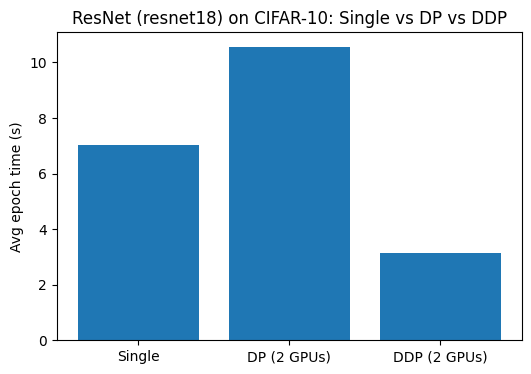

In [7]:
results = {
    "single": single_times,
    "dp": dp_times,
    "ddp": ddp_times,
}

print("Results (epoch times in seconds):")
for k, v in results.items():
    print(k, ":", v)

# Simple speedup vs single GPU (using mean epoch time)

def mean_or_none(x):
    return float(np.mean(x)) if x is not None else None

t_single = mean_or_none(results["single"])
t_dp     = mean_or_none(results["dp"])
t_ddp    = mean_or_none(results["ddp"])

print("\nAverage epoch times:")
print(f"Single: {t_single:.3f} s" if t_single else "Single: N/A")
print(f"DP:     {t_dp:.3f} s"     if t_dp     else "DP: N/A")
print(f"DDP:    {t_ddp:.3f} s"    if t_ddp    else "DDP: N/A")

if t_single and t_dp:
    print(f"\nSpeedup DP vs Single:  {t_single / t_dp:.2f}x")
if t_single and t_ddp:
    print(f"Speedup DDP vs Single: {t_single / t_ddp:.2f}x")

labels = []
times = []
if t_single:
    labels.append("Single")
    times.append(t_single)
if t_dp:
    labels.append("DP (2 GPUs)")
    times.append(t_dp)
if t_ddp:
    labels.append("DDP (2 GPUs)")
    times.append(t_ddp)

plt.figure(figsize=(6, 4))
plt.bar(labels, times)
plt.ylabel("Avg epoch time (s)")
plt.title(f"ResNet ({MODEL_NAME}) on CIFAR-10: Single vs DP vs DDP")
plt.show()
